In [2]:
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)

import numpy as np
import h5py as h5
from scipy import optimize as opt
from scipy.signal import savgol_filter
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from os import path

from importlib import reload
from cassie import *

%matplotlib inline


def fringe(nu, nu_0, ramsey_period, amp, offset):
    return amp*np.cos(np.pi*(nu-nu_0)/(ramsey_period))**2. + offset


def rabi(t, nu, delta, gamma):
    s = np.sin(np.pi*np.sqrt(nu*nu + 4*delta*delta)*t)
    a = nu*nu/(nu*nu + 4*delta*delta)
    d = np.exp(-np.abs(gamma)*t)
    return a*(s*s*d + 0.5*(1-d))*(t>0)

p:	 0.08160238052463725 	+/-	 0.06473632622882991
q:	 0.7402711597117257 	+/-	 0.0686149368176553
m0:	 794.6791790507933 	+/-	 2.048591587914743
m1:	 736.4622723568925 	+/-	 12.179771865335091
s0:	 17.21326794047221 	+/-	 2.235024391011125
s1:	 10.533207096310088 	+/-	 7.171478109934767
Based on 11521 data points 



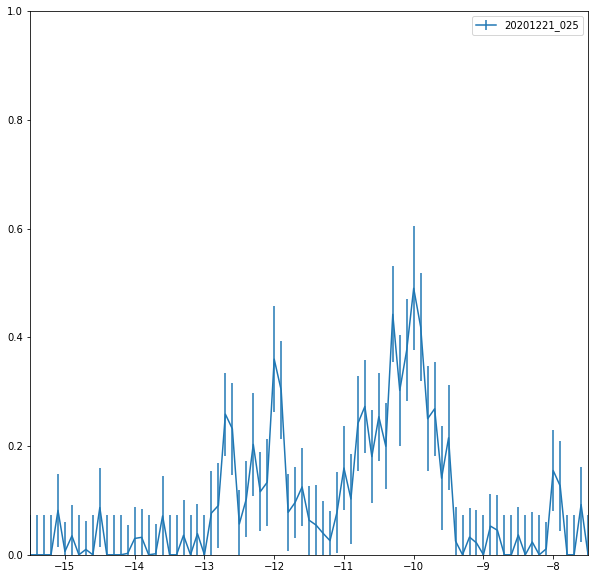

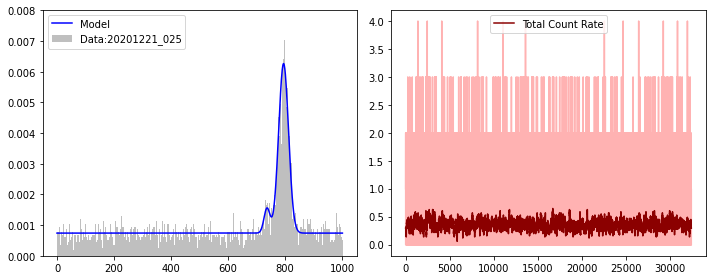

In [3]:
year = "2020"
month = "12"
day = "21"
ymd = year+month+day
nums = ["025"]
xunit = 1e6


mle = MaximumLikelihoodEstimator(default_model)

bigfig, bigax = plt.subplots(figsize = (10, 10))

biggest_x = -np.inf
smallest_x = np.inf

for n in nums:
    fname = "tests/test_data/20201221_025_scan.h5"
    data = h5.File(fname, 'r', swmr = True)
    scope = np.copy(data['osc_0'])
    
    indy_var = np.array([d[0] for d in data['analysis']])
    data.close()

    trace_dist = np.zeros(len(scope[0]))
    timebins = np.arange(len(scope[0]))
    digitised = {v:[] for v in indy_var}
    all_hits = []
    
    counttracker = np.zeros(len(scope))
    
    for k, trace in enumerate(scope):
        edges = locate_edges(trace).tolist()
        digitised[indy_var[k]] += edges
        all_hits += edges
        counttracker[k] = len(edges)
        trace_dist[edges] += 1

    mle.set_data(np.array(all_hits).reshape(1, -1))

    popt, pcov = mle.estimate(
        p = 0.5,
        q = 0.5,
        m0 = 795,
        m1 = 739,
        s0 = 10.,
        s1 = 20.
    )
    
    newfixes = {'q':popt[1],'m0':popt[2], 'm1':popt[3], 's0':popt[4], 's1':popt[5]}
    pnames = default_model.get_param_names()
    for k, val in enumerate(popt):
        print(pnames[k+1]+":\t",val,"\t+/-\t",np.sqrt(pcov[k, k]))
    print("Based on",np.size(all_hits),"data points \n")

    default_model.fix_params(**newfixes)
    
    x = np.sort([v for v in digitised])
    p = np.zeros_like(x)
    sigma = np.zeros_like(x)
    
    for idx, point in enumerate(x):
        mle.set_data(np.array(digitised[point]))
        xpopt, xpcov = mle.estimate(p=0)
        p[idx] = xpopt[0]
        sigma[idx] = np.sqrt(xpcov[0,0])
    
    for k in range(10):
        for idx, point in enumerate(x):
            if idx in locate_outliers(sigma)[0]:
                mle.set_data(np.array(digitised[point]))
                xpopt, xpcov = mle.estimate(p=np.random.uniform())
                p[idx] = xpopt[0]
                sigma[idx] = np.sqrt(xpcov[0,0])
                
    
    for idx, point in enumerate(x):
            if idx in locate_outliers(sigma)[0]:
                if p[idx] == 1 or p[idx] == 0:
                    sigma[idx] = np.mean([sigma[j] for j in range(len(sigma)) if j not in locate_outliers(sigma)[0]])
    
    default_model.fix_params(**{k:None for k in pnames})
    
    model_args = [default_model.get_param_defaults()[p] for p in pnames]
    model_args[0] = timebins
    for k, val in enumerate(popt):
        model_args[k+1] = val

    subfig, subax = plt.subplots(1, 2, figsize = (10, 4))
    subax[0].bar(timebins, trace_dist/np.sum(trace_dist), width = 1, alpha = 0.5, color = 'grey', label = "Data:"+ymd+"_"+n)
    subax[0].plot(timebins, default_model(*model_args), color = 'blue', label = "Model")
    subax[0].legend()
    subax[1].plot(counttracker,alpha=0.3,color='red')
    subax[1].plot(savgol_filter(counttracker,51,0),color='darkred',label="Total Count Rate")
    subax[1].legend()
    subfig.tight_layout()
    
    bigax.errorbar(x*xunit, p, yerr = sigma, label = ymd+"_"+n)
    
    biggest_x = np.maximum(biggest_x, x[-1])
    smallest_x = np.minimum(smallest_x, x[0])

bigax.set_ylim([0, 1])
bigax.set_xlim([xunit*smallest_x, xunit*biggest_x])
bigax.legend()
plt.show()